<a href="https://colab.research.google.com/github/rogerioag/rea-comp04-compiladores/blob/main/jupyter-notebooks/02-comp-analise-sintatica-cmmparser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Sintática



# Introdução



# Preparação do Ambiente



In [99]:
!pip install ply
!pip install anytree
!pip install graphviz
!pip install llvmlite
!jupyter nbextension install https://rawgit.com/jfbercher/small_nbextensions/master/highlighter.zip  --user
!jupyter nbextension enable highlighter/highlighter

Downloading: https://rawgit.com/jfbercher/small_nbextensions/master/highlighter.zip -> /tmp/tmpys_gg4/highlighter.zip
Extracting: /tmp/tmpys_gg4/highlighter.zip -> /root/.local/share/jupyter/nbextensions
Enabling notebook extension highlighter/highlighter...
      - Validating: OK


# Copiando Módulos do Projeto

Aqui iremos copiar o projeto `rea-comp04-compiladores` do repositório do [`github`](https://github.com/rogerioag/rea-comp04-compiladores):

```bash
git clone https://github.com/rogerioag/rea-comp04-compiladores.git
```
Iremos copiar os módulos e os arquivos de testes para o diretório de conteúdo do _notebook_, o __content__.


In [100]:
! rm -rf rea-comp04-compiladores
! git clone https://github.com/rogerioag/rea-comp04-compiladores.git
! cp -R rea-comp04-compiladores/cmmcompiler/* .
! cp -R rea-comp04-compiladores/cmmcompiler/tests/* .


Cloning into 'rea-comp04-compiladores'...
remote: Enumerating objects: 470, done.
remote: Counting objects: 100% (470/470), done.
remote: Compressing objects: 100% (370/370), done.
remote: Total 470 (delta 264), reused 234 (delta 89), pack-reused 0
Receiving objects: 100% (470/470), 2.87 MiB | 2.55 MiB/s, done.
Resolving deltas: 100% (264/264), done.


In [101]:
import ply.yacc as yacc
from lexer import tokens
import re as regex

from sys import argv, exit

import logging

logging.basicConfig(
     level = logging.DEBUG,
     filename = "cmmcompiler.log",
     filemode = "w",
     format = "%(filename)10s:%(lineno)4d:%(message)s"
)
log = logging.getLogger()

from lexer import TOKENS_SYMBOLS
from tree import TreeNode

O conjunto de regras do `parser` está organizado em múltiplos arquivos e as inicializações e importações são feitas no arquivo `parser/grammar/__init__.py`.

Os aquivos com as regras são importados na sequência:
```python
from .declarations import *
from .expressions import *
from .operations import *
from .params import *
from .types import *
from .statements import *
```

Aqui vamos incluir os conteúdos de cada um dos arquivos. O conteúdo de `parser/grammar/declarations.py`:

In [106]:
%%writefile parser/grammar/declarations.py

from lexer import TOKENS_SYMBOLS
from tree import TreeNode

def p_declaration_list(parser):
    """declaration-list : declaration-list declaration
                        | declaration
    """
    parser[0] = TreeNode(id='declaration-list')

    [node, subtree] = parser[:2]

    if len(parser) > 2:
        node.insert_nodes(subtree.nodes())
        [dec] = parser[2:3]
        node.insert_node(dec)
        pass
    else:
        node.insert_node(subtree)
    pass

def p_declaration(parser):
    """declaration : var-declaration
                   | fun-declaration
    """
    parser[0] = TreeNode(id='declaration')

    [node, subtree] = parser

    node.insert_node(subtree)
    pass

def p_var_declaration(parser):
    """var-declaration : type-specifier id SEMICOLON
                       | type-specifier id LBRACKETS number RBRACKETS SEMICOLON
    """
    parser[0] = TreeNode(id='var-declaration')

    [node, type_spec, id_node, symbol] = parser[:4]

    node.insert_node(type_spec)
    node.insert_node(id_node)


    if TOKENS_SYMBOLS.get('SEMICOLON') == symbol:
        node.insert_node_with_child(TreeNode(id='SEMICOLON'), TreeNode(raw=TOKENS_SYMBOLS.get('SEMICOLON')))
        pass
    elif TOKENS_SYMBOLS.get('LBRACKETS') == symbol:
        node.insert_node_with_child(TreeNode(id='LBRACKETS'), TreeNode(raw=TOKENS_SYMBOLS.get('LBRACKETS')))

        [number] = parser[4:5]
        node.insert_node(number)

        node.insert_node_with_child(TreeNode(id='RBRACKETS'), TreeNode(raw=TOKENS_SYMBOLS.get('RBRACKETS')))

        node.insert_node_with_child(TreeNode(id='SEMICOLON'), TreeNode(raw=TOKENS_SYMBOLS.get('SEMICOLON')))

        pass

    pass

def p_fun_declaration(parser):
    """fun-declaration : type-specifier id LPAREN params RPAREN compound-stmt"""
    parser[0] = TreeNode(id='fun-declaration')

    [node, type_spec, id_node, _, params, _, compound] = parser

    node.insert_node(type_spec)
    node.insert_node(id_node)
    node.insert_node_with_child(TreeNode(id='LPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('LPAREN')))
    node.insert_node(params)
    node.insert_node_with_child(TreeNode(id='RPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('RPAREN')))
    node.insert_node(compound)

    pass

def p_local_declarations(parser):
    """local-declarations : local-declarations var-declaration
                          | empty
    """
    parser[0] = TreeNode(id='local-declarations')

    [node, subtree] = parser[:2]

    node.insert_node(subtree)

    if len(parser) > 2:
        [var] = parser[2:3]
        node.insert_node(var)
        pass
    pass


Overwriting parser/grammar/declarations.py


Conteúdo de `parser/grammar/expressions.py`:

In [107]:
%%writefile parser/grammar/expressions.py

from lexer import TOKENS_SYMBOLS
from tree import TreeNode

def p_expressions(parser):
    """expression : var ATTRIBUTION expression
                  | simple-expression
    """
    parser[0] = TreeNode(id='expression')

    [node, subtree] = parser[:2]

    node.insert_node(subtree)
    if len(parser) > 2:
        [_, exp] = parser[2:4]
        attrib_sym = TreeNode(raw=TOKENS_SYMBOLS.get('ATTRIBUTION'))
        attrib_node = TreeNode(id='ATTRIBUTION')
        attrib_node.insert_node(attrib_sym)
        node.insert_node(attrib_node)

        node.insert_node(exp)
        pass
    pass

def p_simple(parser):
    """simple-expression : additive-expression relop additive-expression
                         | additive-expression
    """
    parser[0] = TreeNode(id='simple-expression')

    [node, add] = parser[:2]

    node.insert_node(add)
    if len(parser) > 2:
        [relop, addi] = parser[2:4]
        node.insert_node(relop)
        node.insert_node(addi)
        pass
    pass

def p_additive(parser):
    """additive-expression : additive-expression addop term
                           | term
    """
    parser[0] = TreeNode(id='additive-expression')

    [node, subtree] = parser[:2]

    node.insert_node(subtree)
    if len(parser) > 2:
        [addop, term] = parser[2:4]
        node.insert_node(addop)
        node.insert_node(term)
        pass
    pass


Overwriting parser/grammar/expressions.py


Conteúdo de `parser/grammar/operations.py`:

In [108]:
%%writefile parser/grammar/operations.py

from lexer import TOKENS_SYMBOLS
from tree import TreeNode

def get_token_by_raw(raw):
    
    for (token, value) in TOKENS_SYMBOLS.items():
        if value == raw:
            return token
        pass

    return None

def p_relational(parser):
    """relop : LESS_EQUAL
             | LESS
             | GREATER
             | GREATER_EQUAL
             | EQUALS
             | DIFFERENT
    """
    [_, raw] = parser
    parser[0] = TreeNode(id=get_token_by_raw(raw))
    parser[0].insert_node(TreeNode(raw=raw))
    pass

def p_addition(parser):
    """addop : PLUS
             | MINUS
    """
    [_, raw] = parser
    parser[0] = TreeNode(id=get_token_by_raw(raw))
    parser[0].insert_node(TreeNode(raw=raw))
    pass

def p_multiplication(parser):
    """mulop : TIMES
             | DIVIDE
    """
    [_, raw] = parser
    parser[0] = TreeNode(id=get_token_by_raw(raw))
    parser[0].insert_node(TreeNode(raw=raw))
    pass


Overwriting parser/grammar/operations.py


Conteúdo de `parser/grammar/params.py`:

In [109]:
%%writefile parser/grammar/params.py

from lexer import TOKENS_SYMBOLS
from tree import TreeNode

import logging
log = logging.getLogger()

def p_params(parser):
    """params : param-list
              | void
    """
    parser[0] = TreeNode(id='params')

    [node, subtree] = parser
    node.insert_node(subtree)
    pass

def p_params_error(parser):
    """params : error
    """
    print("Erro: 'param-list' ou 'void' esperado.")
    parser[0] = TreeNode(id='ERROR::{}'.format(parser.lineno(1)))

    [node, subtree] = parser
    node.insert_node(subtree)
    
    log.error("Syntax error parsing 'params' rule at line {}".format(parser.lineno(1)))
        
    pass

def p_param_list(parser):
    """param-list : param-list COMMA param
                  | param
    """
    parser[0] = TreeNode(id='param-list')

    [node, subtree] = parser[:2]

    if len(parser) > 2:
        node.insert_nodes(subtree.nodes())

        [_, param] = parser[2:4]
        node.insert_node_with_child(TreeNode(id='COMMA'), TreeNode(raw=TOKENS_SYMBOLS.get('COMMA')))
        node.insert_node(param)
    else:
        node.insert_node(subtree)


    pass

def p_param(parser):
    """param : type-specifier id
             | type-specifier id LBRACKETS RBRACKETS
    """
    parser[0] = TreeNode(id='param')

    [node, subtree, id_node] = parser[:3]
    node.insert_node(subtree)
    node.insert_node(id_node)

    if len(parser) > 3:
        node.insert_node_with_child(TreeNode(id='LBRACKETS'), TreeNode(raw=TOKENS_SYMBOLS.get('LBRACKETS')))
        node.insert_node_with_child(TreeNode(id='RBRACKETS'), TreeNode(raw=TOKENS_SYMBOLS.get('RBRACKETS')))
        pass

    pass

Overwriting parser/grammar/params.py


Conteúdo de `parser/grammar/types.py`:

In [110]:
%%writefile parser/grammar/types.py

from lexer import TOKENS_SYMBOLS
from tree import TreeNode

def p_type_specifier(parser):
    """type-specifier : int
                      | void
    """
    parser[0] = TreeNode(id='type-specifier')
    [node, type_node] = parser

    node.insert_node(type_node)
    pass

def p_void(parser):
    """void : VOID """
    
    parser[0] = TreeNode(id='VOID')
    [node, lexeme] = parser

    node.insert_node(TreeNode(raw=lexeme))
    pass

def p_int(parser):
    """int : INT """
    
    parser[0] = TreeNode(id='INT')
    [node, lexeme] = parser

    node.insert_node(TreeNode(raw=lexeme))

    pass

Overwriting parser/grammar/types.py


Conteúdo de `parser/grammar/statements.py`:

In [111]:
%%writefile parser/grammar/statements.py

from lexer import TOKENS_SYMBOLS
from tree import TreeNode

def p_statement_list(parser):
    """statement-list : statement-list statement
                      | empty
    """
    parser[0] = TreeNode(id='statement-list')

    [node, subtree] = parser[:2]

    if len(parser) > 2:
        node.insert_nodes(subtree.nodes())
        [stmt] = parser[2:3]
        node.insert_node(stmt)
        pass
    pass

def p_statement(parser):
    """statement : expression-stmt
                 | compound-stmt
                 | selection-stmt
                 | iteration-stmt
                 | return-stmt
    """
    parser[0] = TreeNode(id='statement')

    [node, subtree] = parser

    node.insert_node(subtree)
    pass

def p_expression(parser):
    """expression-stmt : expression SEMICOLON
                       | SEMICOLON
    """
    parser[0] = TreeNode(id='expression-stmt')

    [node, leaf] = parser[:2]


    if TOKENS_SYMBOLS.get('SEMICOLON') == leaf:
        leaf = TreeNode(id='SEMICOLON', raw=leaf)


    node.insert_node(leaf)

    if len(parser) > 2:
        node.insert_node_with_child(TreeNode(id='SEMICOLON'), TreeNode(raw=TOKENS_SYMBOLS.get('SEMICOLON')))
        pass

    pass

def p_compound(parser):
    """compound-stmt : LBRACES local-declarations statement-list RBRACES"""

    parser[0] = TreeNode(id='compound-stmt')

    [node, _, local_decl, stmt_list, _] = parser

    node.insert_node_with_child(TreeNode(id='LBRACES'), TreeNode(raw=TOKENS_SYMBOLS.get('LBRACES')))
    node.insert_node(local_decl)
    node.insert_node(stmt_list)
    node.insert_node_with_child(TreeNode(id='RBRACES'), TreeNode(raw=TOKENS_SYMBOLS.get('RBRACES')))
    
    pass

def p_selection(parser):
    """selection-stmt : IF LPAREN expression RPAREN statement
                      | IF LPAREN expression RPAREN statement ELSE statement
    """
    parser[0] = TreeNode(id='selection-stmt')

    [node, _, _, exp, _, stmt] = parser[:6]

    node.insert_node_with_child(TreeNode(id='IF'), TreeNode(raw=TOKENS_SYMBOLS.get('IF')))
    node.insert_node_with_child(TreeNode(id='LPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('LPAREN')))
    node.insert_node(exp)
    node.insert_node_with_child(TreeNode(id='RPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('RPAREN')))
    node.insert_node(stmt)

    if len(parser) > 6:
        [_, stmt] = parser[6:8]
        node.insert_node_with_child(TreeNode(id='ELSE'), TreeNode(raw=TOKENS_SYMBOLS.get('ELSE')))
        node.insert_node(stmt)
        pass

    pass

def p_iteration(parser):
    """iteration-stmt : WHILE LPAREN expression RPAREN statement"""
    
    parser[0] = TreeNode(id='iteration-stmt')

    [node, _, _, exp, _, stmt] = parser

    node.insert_node_with_child(TreeNode(id='WHILE'), TreeNode(raw=TOKENS_SYMBOLS.get('WHILE')))
    node.insert_node_with_child(TreeNode(id='LPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('LPAREN')))
    node.insert_node(exp)
    node.insert_node_with_child(TreeNode(id='RPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('RPAREN')))
    node.insert_node(stmt)
    pass

def p_return(parser):
    """return-stmt : RETURN SEMICOLON
                   | RETURN expression SEMICOLON
    """
    parser[0] = TreeNode(id='return-stmt')

    [node, _, leaf] = parser[:3]

    if TOKENS_SYMBOLS.get('SEMICOLON') == leaf:
        leaf = TreeNode(id='SEMICOLON', raw=leaf)

    node.insert_node_with_child(TreeNode(id='RETURN'), TreeNode(raw=TOKENS_SYMBOLS.get('RETURN')))

    node.insert_node(leaf)

    if len(parser) > 3:
        leaf = TreeNode(id='SEMICOLON', raw=TOKENS_SYMBOLS.get('SEMICOLON'))

    pass


Overwriting parser/grammar/statements.py


Conteúdo final de `parser/grammar/__init__.py`:

In [113]:
%%writefile parser/grammar/__init__.py

import ply.yacc as yacc
from lexer import tokens
import re as regex

from sys import argv, exit

import logging

logging.basicConfig(
     level = logging.DEBUG,
     filename = "cmmcompiler.log",
     filemode = "w",
     format = "%(filename)10s:%(lineno)4d:%(message)s"
)
log = logging.getLogger()

from lexer import TOKENS_SYMBOLS
from tree import TreeNode

from .declarations import *
from .expressions import *
from .operations import *
from .params import *
from .types import *
from .statements import *

def p_program(parser):
    """program : declaration-list"""

    global syntax_tree

    parser[0] = TreeNode(id='program')

    [node, declaration_list] = parser

    node.insert_node(declaration_list)

    syntax_tree = parser[0]
    
    pass

def p_var(parser):
    """var : id
           | id LBRACKETS expression RBRACKETS
    """
    parser[0] = TreeNode(id='var')

    [node, id_node] = parser[:2]

    node.insert_node(id_node)

    if len(parser) > 2:
        [_, expression] = parser[2:4]
        node.insert_node_with_child(TreeNode(id='LBRACKETS'), TreeNode(raw=TOKENS_SYMBOLS.get('LBRACKETS')))
        node.insert_node(expression)
        node.insert_node_with_child(TreeNode(id='RBRACKETS'), TreeNode(raw=TOKENS_SYMBOLS.get('RBRACKETS')))
        pass
    pass


# TODO: Estava faltando term. Verificar a montagem do nó.

def p_term(parser):
    """term : term mulop factor
            | factor
    """
    parser[0] = TreeNode(id='term')

    [node, leaf] = parser[:2]
    node.insert_node(leaf)

    if len(parser) > 2:
        [mulop] = parser[2:3]
        node.insert_node(mulop)
        [factor] = parser[3:4]
        node.insert_node(factor)
        pass
    pass

def p_factor(parser):
    """factor : LPAREN expression RPAREN
              | var
              | call
              | number
    """
    parser[0] = TreeNode(id='factor')

    [node, leaf] = parser[:2]

    if TOKENS_SYMBOLS.get('LPAREN') == leaf:
        [exp] = parser[2:3]

        node.insert_node_with_child(TreeNode(id='LPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('LPAREN')))
        node.insert_node(exp)
        node.insert_node_with_child(TreeNode(id='RPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('RPAREN')))
    else:
        node.insert_node(leaf)
        pass

    pass

def p_call(parser):
    """call : id LPAREN args RPAREN"""
    parser[0] = TreeNode(id='call')

    [node, id_raw, _, args, _] = parser

    id_node = TreeNode(id='ID')
    id_node.insert_node(TreeNode(raw=id_raw))

    node.insert_node(id_node)
    node.insert_node_with_child(TreeNode(id='LPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('LPAREN')))
    node.insert_node(args)
    node.insert_node_with_child(TreeNode(id='RPAREN'), TreeNode(raw=TOKENS_SYMBOLS.get('RPAREN')))
    pass

def p_id(parser):
    """id : ID"""
    parser[0] = TreeNode(id='ID')
    [node, id_raw] = parser

    node.insert_node(TreeNode(raw=id_raw))
    pass

def p_number(parser):
    """number : NUMBER"""
    parser[0] = TreeNode(id='NUMBER')
    [node, number] = parser

    node.insert_node(TreeNode(raw=number))
    pass

def p_args(parser):
    """args : arg-list
            | empty
    """
    parser[0] = TreeNode(id='args')
    [node, leaf] = parser

    node.insert_node(leaf)
    pass

def p_arg_list(parser):
    """arg-list : arg-list COMMA expression
                | expression
    """
    parser[0] = TreeNode(id='arg-list')
    [node, leaf] = parser[:2]

    node.insert_node(leaf)
    if len(parser) > 2:
        [_, exp] = parser[2:4]
        node.insert_node_with_child(TreeNode(id='COMMA'), TreeNode(raw=TOKENS_SYMBOLS.get('COMMA')))
        node.insert_node(exp)
        pass
    pass

def p_empty(parser):
    """empty :"""
    parser[0] = TreeNode(id='EMPTY')
    pass

def p_error(parser):

    if parser:
        token = parser
        print("Erro:[{line},{column}]: Erro próximo ao token '{token}'".format(
            line=token.lineno, column=token.lineno, token=token.value))
    pass

Overwriting parser/grammar/__init__.py


Conteúdo do `parser/__init__.py`:

In [114]:
%%writefile parser/__init__.py
import ply.yacc as yacc
from lexer import tokens
from .grammar import *

# parser = yacc.yacc(start='program')
parser = yacc.yacc(method="LALR", optimize=True, start='program', debug=True,
                   debuglog=log, write_tables=False, tabmodule='cmm_parser_tab')
 

Overwriting parser/__init__.py


Executando o código do `parser` utilizando o código principal do `cmmcompiler`:

In [115]:
%%writefile main.py

import utils
from lexer import get_tokens
from parser import parser
from semantic import sema, Semantic
from gencode import gencode, GenCode
from tree import TreeNode

import logging
logging.basicConfig(
    filename = "cmmcompiler.log",
    encoding='utf-8',
    level = logging.DEBUG,
    filemode = "w",
    format = "%(filename)10s:%(lineno)4d:%(message)s")
log = logging.getLogger()

syntax_tree = None
reduced_syntax_tree = None

def execute_lexical_analysis(source_input):
    log.info("[lexer]: Executing Lexical Analysis.")
    for token in get_tokens(source_input):
        print(token.type, token.value)
    return

def execute_syntax_analisys(source_input):
    log.info("[parser]: Executing Syntax Analysis.")
    syntax_tree = parser.parse(source_input)
    if syntax_tree != ():
        print("Generating Syntax Tree Graph...")
        graph = utils.Graph(utils.args.file, 'Sintax Tree')
        # program = parser.parse(source_input)
        syntax_tree.render(graph)
        graph.export()
    return syntax_tree

def execute_semantic_analisys(syntax_tree):
    log.info("[sema]: Executing Semantic Analysis.")
    sema = Semantic(syntax_tree)
    sema.check_semantic_rules()
    return reduced_syntax_tree

def execute_code_generation(reduced_syntax_tree):
    log.info("[gencode]: Executing Code Generation.")
    gencode = GenCode(reduced_syntax_tree)
    gencode.generate()
    return

if __name__ == '__main__':
  
  # __file__ = "02-comp-analise-sintatica-cmmparser.ipynb"

  with open(utils.args.file) as file:
      source_input = file.read()
      if utils.args.lexer:
          execute_lexical_analysis(source_input)    
      pass

      if utils.args.parser:
          syntax_tree = execute_syntax_analisys(source_input) 
      pass
        
      if utils.args.semantic:
          if syntax_tree != ():
              reduced_syntax_tree = execute_semantic_analisys(syntax_tree)
          else:
              syntax_tree = execute_syntax_analisys(source_input)
              reduced_syntax_tree = execute_semantic_analisys(syntax_tree)
          pass
      pass

      if utils.args.gencode:
          if reduced_syntax_tree != None:
              execute_code_generation(reduced_syntax_tree)
          else:
              syntax_tree = execute_syntax_analisys(source_input)
              if syntax_tree != ():
                  reduced_syntax_tree = execute_semantic_analisys(syntax_tree)
                  execute_code_generation(reduced_syntax_tree)
              pass

      pass
        
  pass


Overwriting main.py


In [116]:
! python main.py -p prog-001.cm

Generating LALR tables
Generating Syntax Tree Graph...


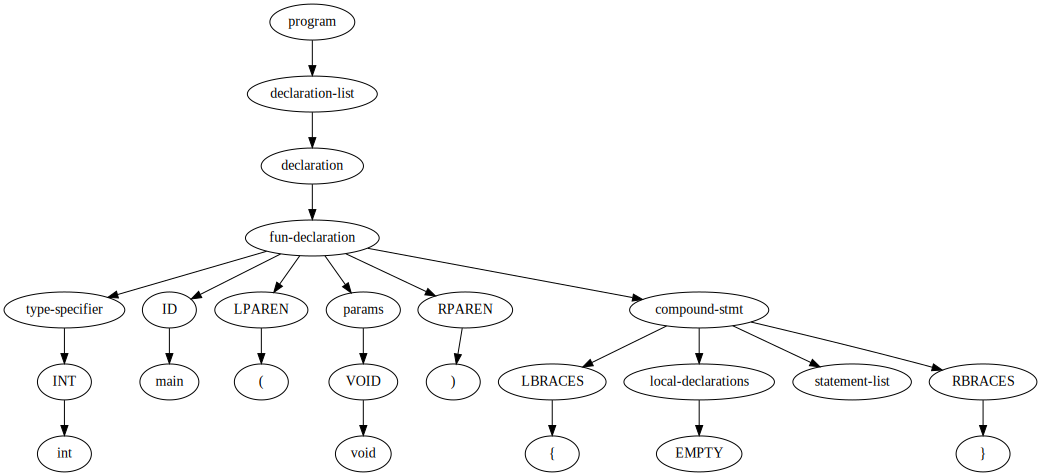

In [117]:
import graphviz

with open("graph.gv") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

## Trabalho de Implementação

Foram feitas algumas alterações para incluir o suporte ao tipo `float` e arranjos bidimensionais (matrizes).

```.ebnf
type-specifier ::= int | float | void
var-declaration ::= type-specifier ID ; | type-specifier ID [ NUM ] ; | type-specifier ID [ NUM ] [ NUM ] ;
param ::= type-specifier ID | type-specifier ID [ ] | type-specifier ID [ ] [ ]

```